<a href="https://colab.research.google.com/github/larasauser/master/blob/main/nspi_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NSPI 2

In [51]:
!pip install rasterio
!pip install numpy
!pip install opencv-python
!pip install tqdm

In [52]:
import numpy as np
import rasterio
from rasterio.plot import show
import cv2
import tqdm
from math import sqrt
from tqdm import tqdm

In [110]:
def compute_rmsd(p1, p2):
    return np.sqrt(np.nanmean(p1-p2)**2)

In [133]:
def select_similar_pixels(input_patch, target_patch, gap_mask, stds, m, max_window):
  h,w,b = input_patch.shape
  x_c,y_c = h//2,w//2
  target_pixel = input_patch[x_c,y_c]

  if np.isnan(target_pixel).any():
        return [], []

  similar_pixels = []
  distances = []

  for i in range(h):
    for j in range(w):
      if gap_mask[i,j]:
        continue

      candidate = input_patch[i,j]

      if np.isnan(candidate).any():
        continue
      rmsd = np.sqrt(np.mean((candidate - target_pixel) ** 2))
      threshold = np.sum([2*stds[k]/m for k in range(b)])/b
      if rmsd <= threshold:
          similar_pixels.append(((i,j),candidate))
          distances.append(np.linalg.norm([i-x_c, j-y_c]))
  return similar_pixels, distances

In [137]:
def predict_pixel_value(similar_pixels, distances, input_patch, target_patch, stds, m, max_window, input_central, target_central):
  if len(similar_pixels)==0:
    return None #use histogram matching if no similar pixel available

  rmsds = [compute_rmsd(input_patch[i,j],input_central) for (i,j),_ in similar_pixels]
  cds = [r*d for r,d in zip(rmsds,distances)]
  weights = 1/(np.array(cds)+1e-6)
  weights /=weights.sum()

  #Prediction L1 (eq7)
  L1 = np.zeros_like(input_central)
  for w, ((i,j),_) in zip(weights, similar_pixels):
    L1 += w*target_patch[i,j]

  #Prediction L2 (eq8)
  delta = np.zeros_like(input_central)
  for w, ((i,j),_) in zip(weights, similar_pixels):
    delta += w * (target_patch[i,j]-input_patch[i,j])
  L2 = input_central + delta

  #Final ponderation T1,T2 (eq11)
  R1 = np.mean([compute_rmsd(input_patch[i,j], input_central)for (i,j),_ in similar_pixels])
  R2 = np.mean([compute_rmsd(target_patch[i,j],input_patch[i,j])for (i,j),_ in similar_pixels])

  T1 = 1/R1 if R1 != 0 else 1e6
  T2 = 1/R2 if R2 != 0 else 1e6
  T_sum = T1 + T2
  T1, T2 = T1/T_sum, T2/T_sum

  return T1*L1 + T2*L2

In [122]:
def filled_gaps_nspi(target, input_shape, gap_mask, m=20, max_window =151):
  filled = target.copy()
  h,w,b = target.shape
  pad = max_window//2
  padded_target = np.pad(target, ((pad,pad),(pad,pad),(0,0)),mode='reflect')
  padded_input = np.pad(input_image,((pad,pad),(pad,pad),(0,0)),mode='reflect')
  padded_mask = np.pad(gap_mask,((pad,pad),(pad,pad)),mode='constant',constant_values=1)

  stds = np.nanstd(input_image[~gap_mask],axis=0)

  for y in tqdm(range(pad,pad+h)):
    for x in range(pad,pad+w):
      if not gap_mask[y-pad,x-pad]:
        continue

      for window in range(51, max_window +1, 10):
        r = window//2
        input_patch = padded_input[y-r:y+r+1, x-r:x+r+1]
        target_patch = padded_target[y-r:y+r+1, x-r:x+r+1]
        mask_patch = padded_mask[y-r:y+r+1, x-r:x+r+1]

        similar_pixels, distances = select_similar_pixels(
            input_patch, target_patch, mask_patch, stds, m, max_window
        )

        if len(similar_pixels) >= m or window == max_window:
          val = predict_pixel_value(similar_pixels, distances, input_patch, target_patch,stds,m,max_window,
                                    input_patch[r,r], target_patch[r,r])
          if val is not None:
            filled[y-pad,x-pad] = val
          break

  return filled


Application

In [3]:
#Drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [114]:
input_path = '/content/drive/MyDrive/NDVI_herens_Landsat8_10/imputed/NDVI_2023-08-20.tif'
target_path = '/content/drive/MyDrive/NDVI_herens_Landsat8_10/NDVI_herens_Landsat8_10_holes/NDVI_2023-08-20.tif'


In [115]:
import rasterio
import numpy as np

with rasterio.open(input_path) as src:
  input_image=src.read().transpose(1,2,0).astype(np.float32)
  input_profile = src.profile

with rasterio.open(target_path) as src:
  target_image = src.read().transpose(1,2,0).astype(np.float32)
  target_profile = src.profile

In [149]:
count = np.sum(target_image == -9999)
print("Occurrences de -9999 :", count)


Occurrences de -9999 : 0


In [150]:
target_image[target_image == -9999] = np.nan

In [151]:
np.isnan(target_image).any()

np.True_

In [123]:
gap_mask = np.isnan(target_image[:,:,0])

In [138]:
filled_img = filled_gaps_nspi(target_image, input_image, gap_mask, m=20, max_window = 151)

100%|██████████| 757/757 [53:29<00:00,  4.24s/it]


In [144]:
import matplotlib.pyplot as plt
import numpy as np

def show_comparison(input_image, target_image, filled_img, band=0):
    """
    Affiche les images input / target / remplie NSPI pour une bande donnée,
    avec une échelle de couleur fixée entre -1 et 1 (NDVI typique).
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    vmin, vmax = -1, 1  # Échelle fixe NDVI

    titles = ['Input (référence)', 'Target avec trous', 'Image remplie (NSPI)']
    images = [input_image, target_image, filled_img]

    for ax, img, title in zip(axes, images, titles):
        im = ax.imshow(img[:, :, band], cmap='RdYlGn', vmin=vmin, vmax=vmax)
        ax.set_title(title)
        ax.axis('off')
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()


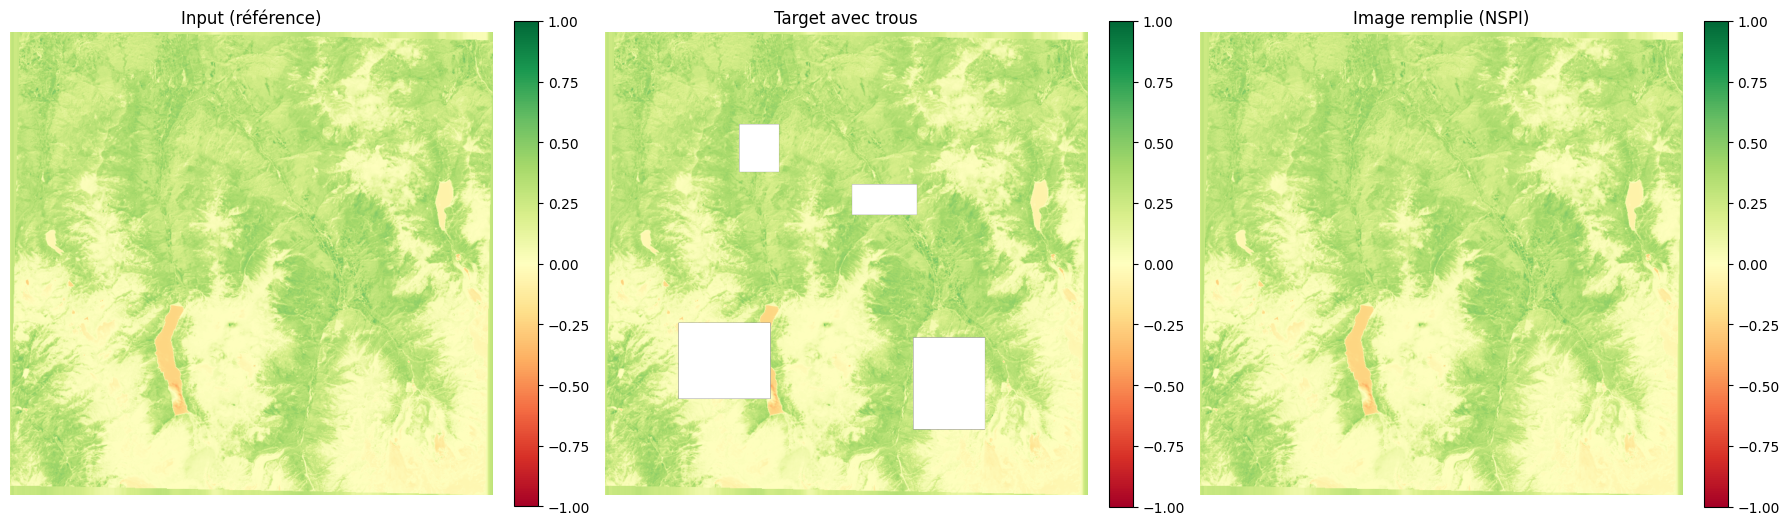

In [152]:
show_comparison(input_image, target_image, filled_img, band=0)

Metrics

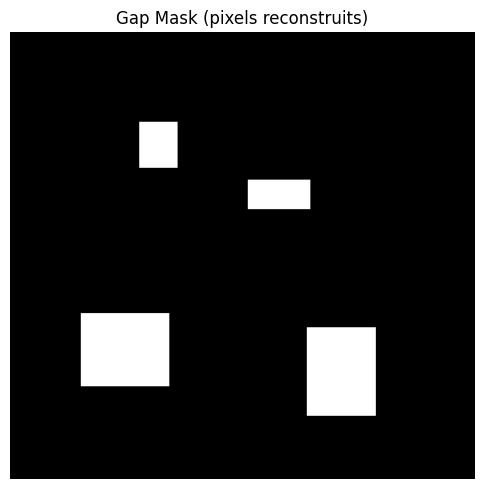

In [153]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.title("Gap Mask (pixels reconstruits)")
plt.imshow(gap_mask, cmap='gray')
plt.axis('off')  # pour enlever les axes, optionnel
plt.show()


In [154]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Extraire uniquement les pixels reconstruits
input_pixels = input_image[gap_mask]
filled_pixels = filled_img[gap_mask]

# RMSE
rmse = np.sqrt(mean_squared_error(input_pixels, filled_pixels))

# R-squared
r2 = r2_score(input_pixels, filled_pixels)

print(f"RMSE: {rmse}")
print(f"R²: {r2}")


RMSE: 1.4089446582140897e-07
R²: 1.0


In [158]:
from skimage.metrics import structural_similarity as ssim

# SSIM entre les deux images sur la zone reconstruite
# On doit extraire la sous-image correspondant aux pixels gap_mask pour SSIM.
# Mais SSIM s'applique en général sur une image 2D, donc on peut appliquer un masque

# Créons des images où les pixels hors gap_mask sont mis à 0 pour éviter d'influencer la comparaison

input_img = np.squeeze(input_image)  # (757, 788)
filled_img = np.squeeze(filled_img)  # (757, 788)

input_masked = np.where(gap_mask, input_img, 0)
filled_masked = np.where(gap_mask, filled_img, 0)

ssim_index, _ = ssim(input_masked, filled_masked, full=True, data_range=2)

print(f"SSIM (sur pixels reconstruits): {ssim_index}")


SSIM (sur pixels reconstruits): 1.0000000004979215


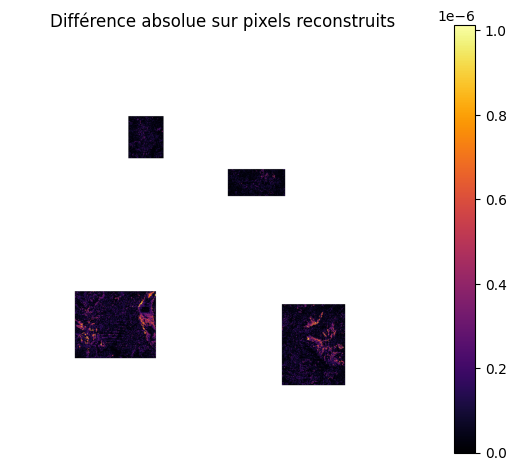

In [159]:
import matplotlib.pyplot as plt
import numpy as np

# Supposons que input_img, filled_img, gap_mask soient déjà définis et bien dimensionnés

# Calcul de la différence (absolue)
diff = np.abs(input_img - filled_img)

# Masquer les pixels hors gap_mask (mettre à NaN ou 0)
diff_masked = np.where(gap_mask, diff, np.nan)  # NaN pour ne rien afficher hors zone reconstruite

plt.figure(figsize=(6,6))
plt.title("Différence absolue sur pixels reconstruits")
im = plt.imshow(diff_masked, cmap='inferno')  # colormap pour bien voir les différences
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.axis('off')
plt.show()


Export

In [160]:
import os
from skimage.io import imsave

In [161]:
output_dir = '/content/drive/MyDrive/NDVI_herens_Landsat8_10/NDVI_herens_Landsat8_10_holes/filled_nspi2'
os.makedirs(output_dir, exist_ok=True)

In [165]:
filename = "NDVI_2023-08-20.tif"  # ou .png selon ton fichier
output_path = os.path.join(output_dir, filename)


In [166]:
imsave(output_path, filled_img)
print(f"Image saved at: {output_path}")

Image saved at: /content/drive/MyDrive/NDVI_herens_Landsat8_10/NDVI_herens_Landsat8_10_holes/filled_nspi2/NDVI_2023-08-20.tif
